# Reproducibility, Privacy in Practice

# Reproducibility

We'll cover:

* pipelines
* eval with random seeds

## Reading the data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/income_data.csv")

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [4]:
cat_columns = ['sex', 'education', 'race']
cont_columns = ['age', 'education-num', 'hours-per-week']
features = cat_columns + cont_columns
target = "target"

# Building the first pipeline

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [6]:
cat_trans = Pipeline(steps=[('onehot', OneHotEncoder(drop='first',
                                                     min_frequency=0.05,
                                                    handle_unknown='infrequent_if_exist'))])
cont_trans = Pipeline(steps=[('scaler', StandardScaler())])

feat_trans = ColumnTransformer(
    transformers=[('categorical', cat_trans, cat_columns),
                  ('continuous', cont_trans, cont_columns)])

def mk_knn(k):
    return Pipeline(steps=[
        ('feature_transform', feat_trans),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])

def mk_tree(d):
    return Pipeline(steps=[
        ('feature_transform', feat_trans),
        ('classifier', DecisionTreeClassifier(max_depth=d))
    ])

In [7]:
mk_tree(3)

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num',
                                                   'hours-per-week'])])),
                ('classifier', DecisionTreeClassifier(max_depth=3))])

# Model evaluation

In [8]:
from sklearn.model_selection import train_test_split
import sklearn.metrics

In [16]:
Xtr, Xte, ytr, yte = train_test_split(df[features], df[target],
                                      test_size=0.3) # no seed
sklearn.metrics.accuracy_score(yte, mk_tree(5).fit(Xtr, ytr).predict(Xte))

0.8099088954857201

<AxesSubplot:ylabel='Frequency'>

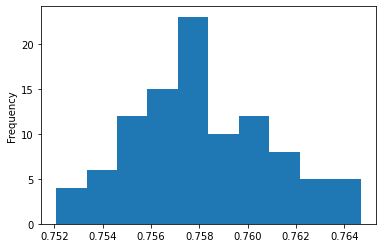

In [19]:
def get_score():
    tr, Xte, ytr, yte = train_test_split(df[features], df[target],
                                      test_size=0.3) # no seed
    return sklearn.metrics.accuracy_score(yte, mk_tree(5).fit(Xtr, ytr).predict(Xte))
pd.Series([get_score() for i in range(100)]).plot.hist()

In [20]:
Xtr, Xte, ytr, yte = train_test_split(df[features], df[target],
                                      test_size=0.3, random_state=123)
sklearn.metrics.accuracy_score(yte, mk_tree(5).fit(Xtr, ytr).predict(Xte))

0.8107278124680111

## Cross-val

In [41]:
from sklearn.model_selection import cross_val_score

In [50]:
cross_val_score(mk_tree(3), df[features], df[target]) # no change

array([0.79594657, 0.80159705, 0.80451474, 0.80712531, 0.80175061])

## Random Seeds for Models

In [51]:
from sklearn.ensemble import RandomForestClassifier

<AxesSubplot:ylabel='Frequency'>

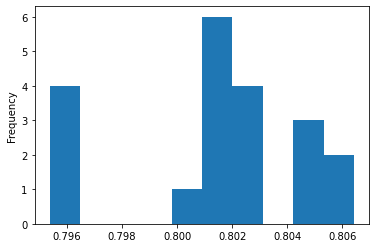

In [56]:
Xtr, Xte, ytr, yte = train_test_split(df[features], df[target],
                                      test_size=0.3, random_state=123)
def mk_forest(d):
    return Pipeline(steps=[
        ('feature_transform', feat_trans),
        ('classifier', RandomForestClassifier(max_depth=d))
    ])
def get_metric():
    model = mk_forest(3).fit(Xtr, ytr)
    return sklearn.metrics.accuracy_score(yte, model.predict(Xte))
pd.Series([get_metric() for i in range(20)]).plot.hist()

In [21]:
import numpy
import matplotlib.pyplot as plt

# Privacy in Practice: Randomization

In [22]:
values = numpy.random.choice([0, 1], 10000) # p = 0.5

In [23]:
values[:10]

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0])

In [24]:
values.mean() # estimate for p

0.4949

In [25]:
values.shape

(10000,)

In [26]:
def randomize(a, theta):
    coins = numpy.random.choice([True, False], p=(theta, (1-theta)), size=a.shape)
    noise = numpy.random.choice([0, 1], size=a.shape)
    response = numpy.array(a)
    response[~coins] = noise[~coins]
    return response

In [27]:
randomize(values, 0.8)[:10]

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [28]:
randomize(values, 0.8).mean()

0.4964

In [29]:
values = numpy.random.choice([0, 1], p=[0.8, 0.2], size=10000) # p = 0.5

In [30]:
values.mean()

0.1971

In [31]:
randomize(values, 0.8).mean()

0.2538

In [32]:
# theta * p + (1-theta) * 1/2
0.8 * 0.2 + (1 - 0.8)*1/2

0.26

In [33]:
# approx. original p
def approx_p(sample, theta):
    return randomize(sample, theta).mean() / theta - (1 - theta) / 2 / theta

In [34]:
approx_p(values, 0.8)

0.20212499999999997

In [35]:
def gen_sample(p):
    return numpy.random.choice([0, 1], 10000, p=(1-p, p))

In [36]:
def show_hists(p, theta):
    approx = [approx_p(gen_sample(p), theta) for _ in range(1000)]
    true_v = [gen_sample(p).mean() for _ in range(1000)]
    plt.hist(approx, bins=15, alpha=0.5, label='noisy')
    plt.hist(true_v, bins=15, alpha=0.5, label='true')
    plt.legend()

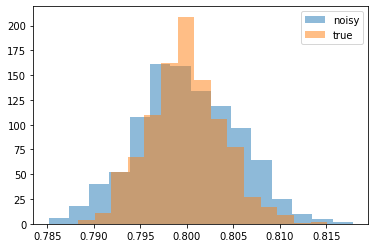

In [37]:
show_hists(0.8, 0.8)

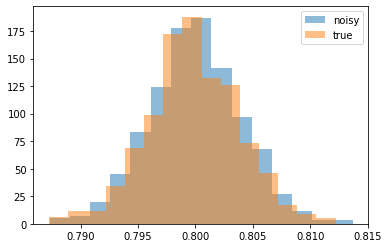

In [38]:
show_hists(0.8, 0.999)

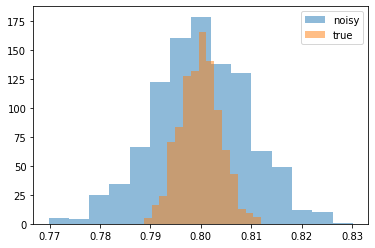

In [39]:
show_hists(0.8, 0.5)

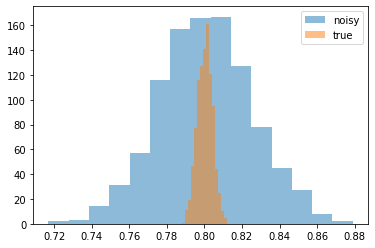

In [40]:
show_hists(0.8, 0.2)

In [21]:
import pandas
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [22]:
df = pandas.read_csv('data/income_data.csv', skipinitialspace=True)

In [23]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,0


In [24]:
df['education'].isin(['Masters', 'Bachelors', 'Doctorate', 'Prof-school'])*1

0        1
1        1
2        0
3        0
4        1
        ..
32556    0
32557    0
32558    0
32559    0
32560    0
Name: education, Length: 32561, dtype: int64

In [25]:
higher_ed = ['Masters', 'Bachelors', 'Doctorate', 'Prof-school']

def mk_randomized_pipeline(theta):
    return Pipeline(steps=[
        ('higher-ed', FunctionTransformer(lambda x: x.isin(higher_ed)*1)),
        ('randomize', FunctionTransformer(randomize, kw_args={'theta': theta}))
    ])

def feature_transform(theta):
    return ColumnTransformer(transformers=[
        ('randomize_ed', mk_randomized_pipeline(theta), ['education']),
        ('age, hours', FunctionTransformer(), ['age', 'hours-per-week']) # maybe feature scale for e.g. SVC
    ])

def mk_model(depth, theta):
    return Pipeline(steps=[
        ('feature_transform', feature_transform(theta)),
        ('classifier', DecisionTreeClassifier(max_depth=depth))
    ])

In [26]:
from sklearn import set_config

In [27]:
set_config(display='diagram')

In [28]:
mk_model(3, 0.5).fit(df, df['target'])

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('randomize_ed',
                                                  Pipeline(steps=[('higher-ed',
                                                                   FunctionTransformer(func=<function mk_randomized_pipeline.<locals>.<lambda> at 0x1335d0550>)),
                                                                  ('randomize',
                                                                   FunctionTransformer(func=<function randomize at 0x1113785e0>,
                                                                                       kw_args={'theta': 0.5}))]),
                                                  ['education']),
                                                 ('age, hours',
                                                  FunctionTransformer(),
                                                  ['age', 'hours-per-week'])])),
                ('classifier', DecisionTreeClassifier(max_depth=3))])

In [29]:
cross_val_score(mk_model(3, 0.5), df, df['target'], cv=10).mean()

0.7701852238120277

In [30]:
df['target'].mean()

0.2408095574460244

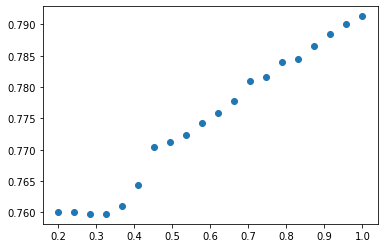

In [31]:
thetas = numpy.linspace(0.2, 1.0, 20)
scores = [cross_val_score(mk_model(3, theta), 
                          df, df['target'], cv=10).mean()
         for theta in thetas]
plt.scatter(thetas, scores)

# If time: Basic model eval and feature selection gone wrong

# Shooting yourself in the foot - correct use of pipelines

In [228]:
from sklearn.linear_model import LogisticRegression

In [229]:
import numpy

In [230]:
k, N = 5000, 500

In [231]:
X = numpy.random.rand(k*N).reshape(N, k)

In [232]:
y = numpy.random.choice([0, 1], N)

In [233]:
from sklearn.feature_selection import SelectKBest

In [234]:
Xp = SelectKBest(k=10).fit_transform(X, y)

In [235]:
import seaborn as sns

In [236]:
cv_scores = pd.DataFrame({
    'full data': cross_val_score(LogisticRegression(max_iter=10_000), X, y, cv=20),
    'selected features': cross_val_score(LogisticRegression(max_iter=10_000), Xp, y, cv=20)}
)

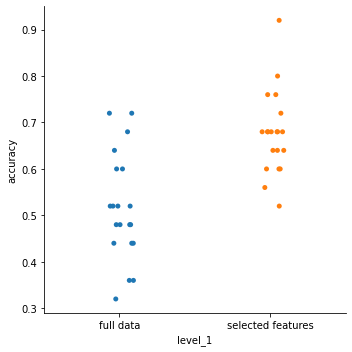

In [237]:
sns.catplot(data=cv_scores.stack().reset_index(name='accuracy'), x='level_1', y='accuracy')

## The right way

In [252]:
from sklearn.feature_selection import SelectKBest

In [256]:
def mk_knn_fs(k):
    return Pipeline(steps=[
        ('feature_transform', feat_trans),
        ('feature_select', SelectKBest(k=10)),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])

In [257]:
mk_knn_fs(20)

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num',
                                                   'hours-per-week'])])),
                ('feature_select', SelectKBest()),
                ('classifier', KNeighborsClassifier(n_neighbors=20))])

<AxesSubplot:>

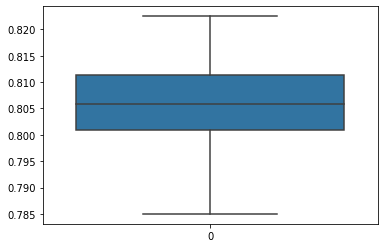

In [261]:
sns.boxplot(data=cross_val_score(mk_knn_fs(20), df[features], df[target], cv=20))